# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
import math
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as ltb

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

import shap
from xgboost import plot_importance

2022-05-16 06:15:30.006999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-16 06:15:30.007030: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('./data.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [4]:
# remove all unknown data
df.drop(df[df.SHSeizComaPast12mos == 2].index, inplace=True)

### for SH events prediction pre processing


In [5]:
y_label = 'SHSeizComaPast12mos'

In [6]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['SHSeizComaPast12mos'])):
        if((row['NumSHSeizComaPast12mos'] >= 1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [7]:
df['Pt_SmokeAmt'] = df['Pt_SmokeAmt'].replace({
    0: 0,1:0, 2:0, 3:0, 5:0, 6:0,
    4: 1
})

In [8]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# {'1.Yes': 0, '2.No': 1, "3.Don't know": 2}

print(get_possible_vals_with_nan(df, y_label))


[1.0, 0.0]


In [9]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay', 'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDecCntCarb', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_HealthProfDiabEdu', 'Pt_GlutFreeDiet', 'Pt_CeliacDr', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_EduLevel', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'HyperglyCritHbA1c', 'HyperglyCritRandGluc', 'R

In [10]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater', 'ExamDaysFromConsent']

df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,...,AtrialFib,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration
0,3963.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876
4,12505.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684
7,26063.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507
14,553.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549
15,13365.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915
20,15799.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739
24,15966.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999
27,6426.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704
34,10659.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979
40,19861.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872


In [11]:
# gender specific data
# number of F and M
# check gender distribution of selected dataset  Gender {'F': 0, 'M': 1, 'T': 2}

gender_groupby = df.groupby('Gender', as_index=False).agg(total= ('PtID','count'))
print(gender_groupby)

   Gender  total
0     0.0   3615
1     1.0   3038
2     2.0      2


In [12]:
# only SH event occured 
is_male = False
if is_male:
    gender_label = 1.0
else:
    gender_label = 0.0

df_sh = df[df[y_label]==0.0]
gender_groupby = df_sh.groupby('Gender', as_index=False).agg(total= ('PtID','count'))
print(gender_groupby)
print(df.shape)
df = df[df['Gender'] == gender_label]
df.shape

   Gender  total
0     0.0    106
1     1.0     99
(6655, 158)


(3615, 158)

In [13]:
def remove_gender_specific_fields(df):
    if is_male:
        drop_list = ['Pt_MenarcheAge','Pt_RegMenstCyc','Pt_IrregMenstCycReas','Pt_CurrPreg','Pt_MiscarriageNum']
        df = df.drop(drop_list, axis = 1)
        return df
    else:
        return df

df = remove_gender_specific_fields(df)

# Divide Dataset

In [14]:
df=df.drop('PtID', axis = 1)

In [15]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
        
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


In [16]:

df.drop(['Lipoatrophy',
 'AgeAtConsent',
 'InsCarbRatDinn',
 'InsNovolog',
 'CGMGlucPctBelow60'], inplace=True, axis=1)
df.head(10)


,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,Pt_InsUnk,...,AtrialFib,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684
14,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549
20,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739
24,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999
34,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979
61,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3799
62,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,29.6249
91,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.4791
93,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3073
100,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.2854


In [17]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [18]:
Y.unique()

array([1., 0.])

# Feature Selection

In [19]:
shape = np.shape(X) 
feature = shape[1] 
n_classes = 2


In [20]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)



In [21]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [  79 2632]
Test -  [0. 1.] [ 27 877]


# Imputations

<AxesSubplot:>

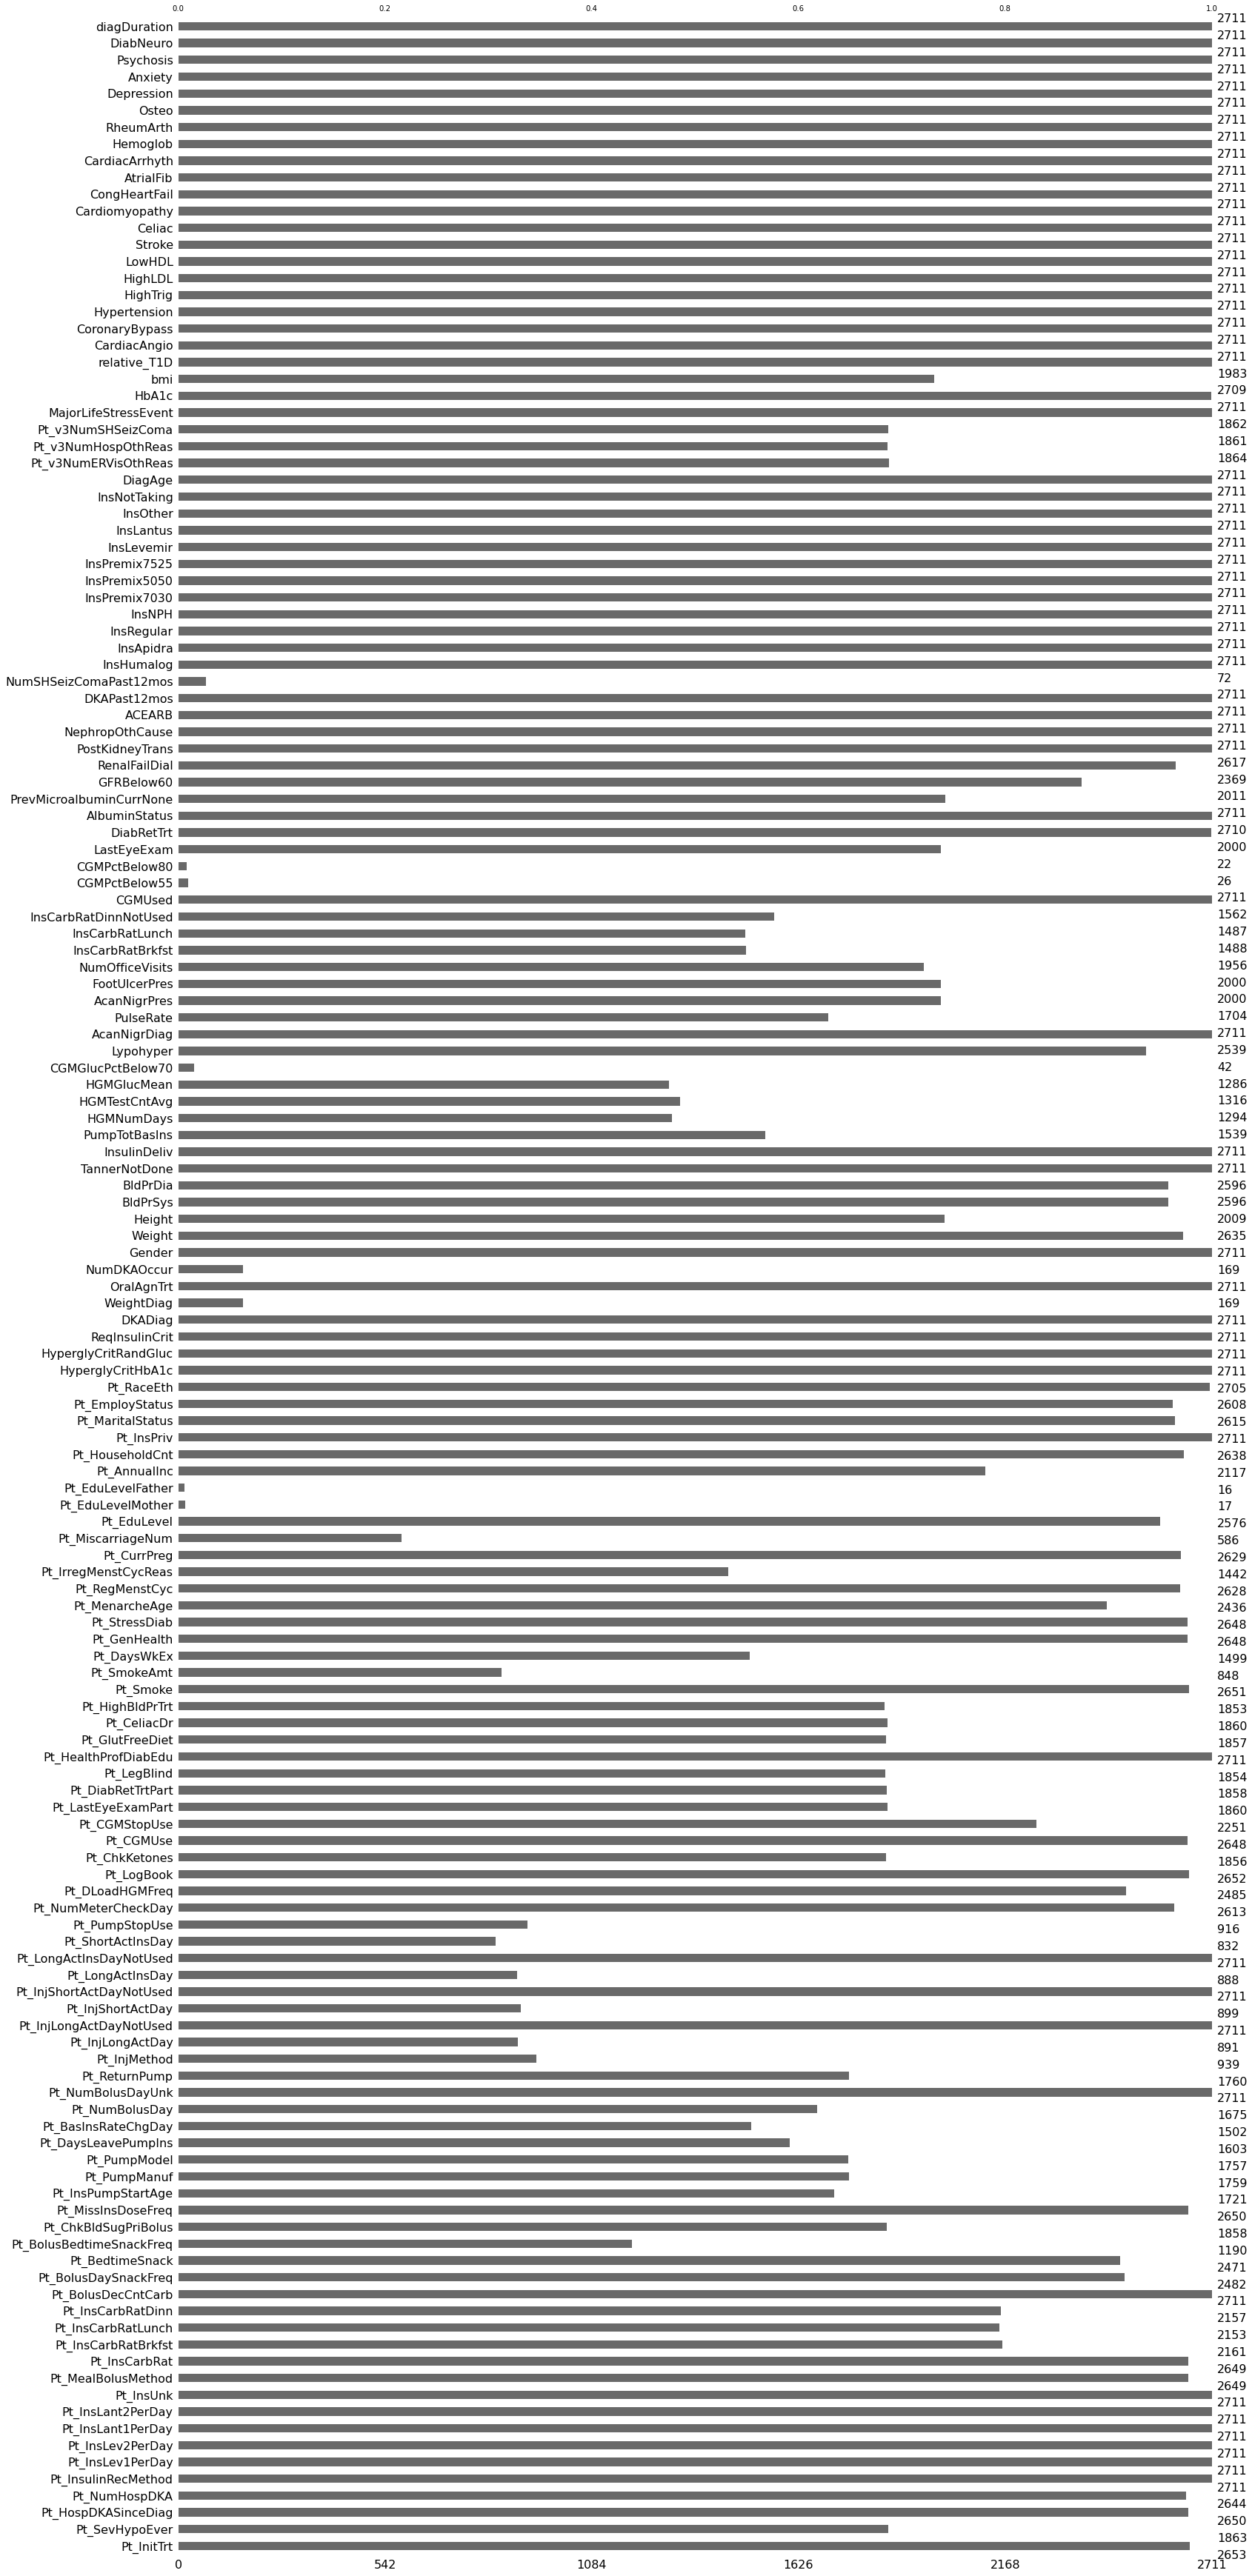

In [22]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [23]:
def plot_roc_curve(fpr, tpr, optimal_idx):
    plt.figure(figsize=(10,5))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [24]:
# use only for XGB classifier with missing values
# X_train_copy = X_train.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)
# X_test_copy = X_test.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

if('NumSHSeizComaPast12mos' in X_train.columns):
    X_train_copy = X_train_copy.drop(['NumSHSeizComaPast12mos'], axis=1)
    X_test_copy = X_test_copy.drop([ 'NumSHSeizComaPast12mos'], axis=1)
if('Pt_v3NumSHSeizComa' in X_train.columns):
    X_train_copy = X_train_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)
    X_test_copy = X_test_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)
# if('Pt_SevHypoEver' in X_train.columns):
#     X_train_copy = X_train_copy.drop(['Pt_SevHypoEver'], axis=1)
#     X_test_copy = X_test_copy.drop(['Pt_SevHypoEver'], axis=1)

feature_list_m = ['Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_InsCarbRatDinn',
       'Pt_BolusDaySnackFreq', 'Pt_DaysLeavePumpIns', 'Pt_NumBolusDay',
       'Pt_InjShortActDay', 'Pt_LongActInsDay', 'Pt_StressDiab',
       'ReqInsulinCrit', 'WeightDiag', 'TannerNotDone', 'HGMNumDays',
       'Lypohyper', 'AcanNigrDiag', 'NumOfficeVisits', 'InsCarbRatBrkfst',
       'InsCarbRatDinnNotUsed', 'CGMPctBelow55', 'GFRBelow60',
        'InsOther', 'Pt_v3NumHospOthReas',
        'diagDuration']

feature_list_f =['NumDKAOccur','DKAPast12mos','Pt_SevHypoEver','Pt_CeliacDr','FootUlcerPres','Pt_GlutFreeDiet',
                'InsCarbRatBrkfst','AcanNigrDiag','AcanNigrPres','Pt_LongActInsDay','ReqInsulinCrit','Pt_HighBldPrTrt',
                'NumOfficeVisits','Pt_InsCarbRatBrkfst','GFRBelow60','OralAgnTrt','Pt_InsCarbRat','Pt_IrregMenstCycReas',
                'Pt_DaysLeavePumpIns','Pt_HealthProfDiabEdu','AlbuminStatus','Pt_PumpModel','LastEyeExam',
                'Pt_NumMeterCheckDay','HighLDL']


# feature_list = ['Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag',
#        'Pt_InsLev1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsCarbRatDinn',
#        'Pt_PumpManuf', 'Pt_DaysLeavePumpIns', 'Pt_ChkKetones',
#        'Pt_HighBldPrTrt', 'Pt_InsPriv', 'WeightDiag', 'HGMNumDays',
#        'Lypohyper', 'AcanNigrDiag', 'AcanNigrPres', 'NumOfficeVisits',
#        'InsCarbRatLunch', 'LastEyeExam', 'AlbuminStatus', 'RenalFailDial',
#         'CardiacAngio',
#        'diagDuration']
# X_train_copy = X_train_copy[feature_list_f]
# X_test_copy = X_test_copy[feature_list_f]
    

In [25]:
kf = KFold(n_splits= 10, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values



from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()




def cross_val_with_missing_val(model,n_splits=5):

    dfs = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        
        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1


    return model



Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.


Accuracy for the fold no. 1 on the test set: 0.9705340699815838, doublecheck: 0.9705340699815838
Accuracy for the fold no. 2 on the test set: 0.9723247232472325, doublecheck: 0.9723247232472325
Accuracy for the fold no. 3 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 4 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 5 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479

 
 ===========   Train Dataset    =============
train ROC score 0.9636701165788157
Threshold value is: 0.9221476956427466


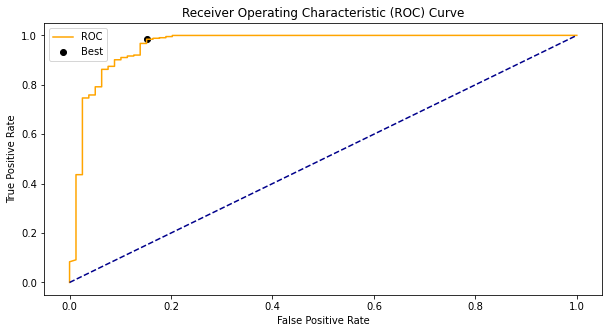

accuracy score:  98.04500184433789
              precision    recall  f1-score   support

         0.0       0.62      0.85      0.72        79
         1.0       1.00      0.98      0.99      2632

    accuracy                           0.98      2711
   macro avg       0.81      0.92      0.85      2711
weighted avg       0.98      0.98      0.98      2711



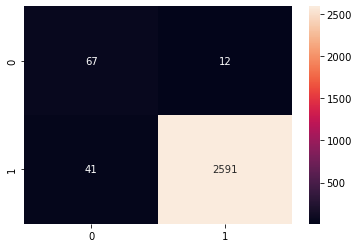

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9756452078010488


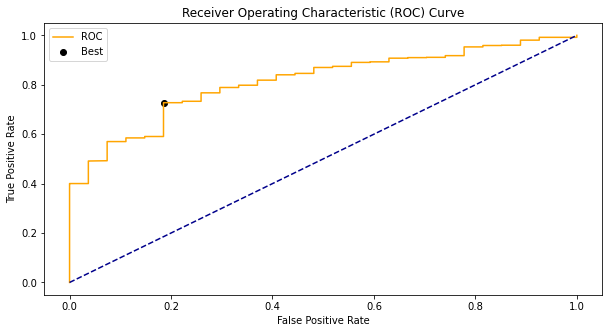

accuracy score:  73.00884955752213
              precision    recall  f1-score   support

         0.0       0.08      0.81      0.15        27
         1.0       0.99      0.73      0.84       877

    accuracy                           0.73       904
   macro avg       0.54      0.77      0.50       904
weighted avg       0.97      0.73      0.82       904



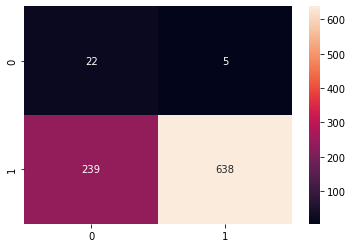

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.8137


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.81481481 0.72748005]
average accuracy:  0.7711474302124245


In [26]:
# HistGradientBoostingClassifier - train with missing values
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


model= HistGradientBoostingClassifier(loss= 'binary_crossentropy',
                                     learning_rate = 0.01,
                                     max_iter= 100,
                                     )          
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)



Accuracy for the fold no. 1 on the test set: 0.9705882352941176, doublecheck: 0.9705882352941176
Accuracy for the fold no. 2 on the test set: 0.974169741697417, doublecheck: 0.974169741697417
Accuracy for the fold no. 3 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 4 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 5 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 6 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 7 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 8 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 9 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 10 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479

 
 ===========   Train Dataset

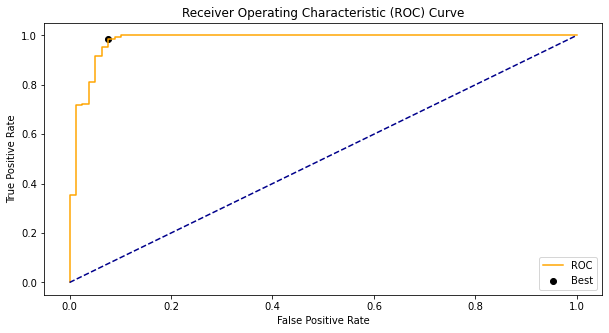

accuracy score:  98.4507561785319
              precision    recall  f1-score   support

         0.0       0.67      0.92      0.78        79
         1.0       1.00      0.99      0.99      2632

    accuracy                           0.98      2711
   macro avg       0.83      0.96      0.88      2711
weighted avg       0.99      0.98      0.99      2711



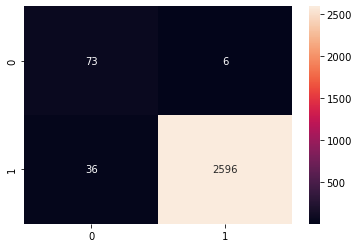

Accuracy of XGB on training set: 0.99


 ===========   Test Dataset    =============
Threshold value is: 2.8558204


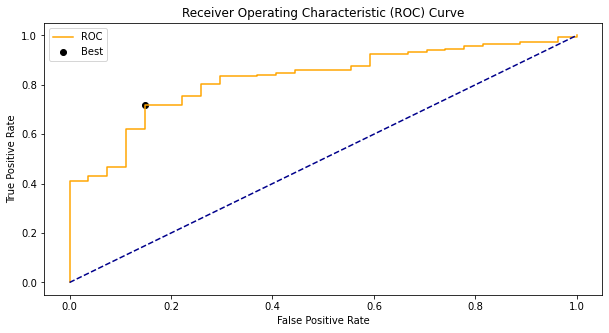

accuracy score:  72.34513274336283
              precision    recall  f1-score   support

         0.0       0.09      0.85      0.16        27
         1.0       0.99      0.72      0.83       877

    accuracy                           0.72       904
   macro avg       0.54      0.79      0.50       904
weighted avg       0.97      0.72      0.81       904



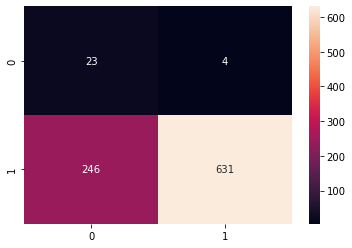

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.8231


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.85185185 0.71949829]
average accuracy:  0.7856750707377845
f1 0.7234513274336284


In [27]:
# xgboost - train with missing values

model=XGBClassifier(
        use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
#         scale_pos_weight = 0.4,
        n_jobs = 0,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
#         objective = 'binary:logistic', 
        objective='multi:softmax',
        min_child_weight = 2,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )

# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model, 10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]


fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test, average = 'micro'))


<AxesSubplot:>

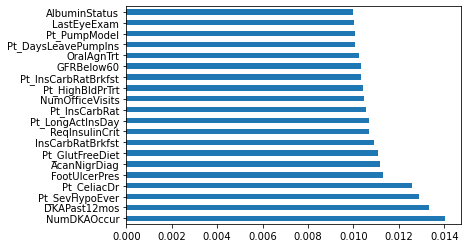

In [28]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feat_importances.nlargest(20).plot(kind='barh')


In [29]:
def draw_boundary(model, X, Y, thresh1, thresh2):
    
    prediction = (model.predict_proba(X)[:,1])
    
    X_axis= np.linspace(start = 0, stop = 1, num = len(prediction))
    d = pd.DataFrame(prediction, columns=['pre'])
    X_axis = pd.DataFrame(X_axis, columns=['x_axis_vals'])
    df = pd.concat([d.reset_index(drop=True), Y.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), X_axis.reset_index(drop=True)], axis=1)
    
    
    # plot histogram
    plt.figure(figsize=(15,7))
    plt.hist(prediction[Y==0], bins=50, label='Positive', alpha=1, color='b', density=True)
    plt.hist(prediction[Y==1], bins=50, label='Negative', alpha=0.5, color='r', density=True)
    plt.xlabel('Probability of being Positive Class', fontsize=10)
    plt.ylabel('Number of records in each bucket', fontsize=10)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', labelsize=10, pad=5)
    plt.show() 
    
    # plot scatter
    plt.figure(figsize=(16, 16))
    colormap = np.array(['k', 'y'])
    cs = df.SHSeizComaPast12mos.to_list()
    categories = np.array(cs).astype(int)
    plt.scatter(df.x_axis_vals, df.pre, s=100, c=colormap[categories], alpha=0.5)
    plt.axhline(y=thresh1)
    plt.axhline(y=thresh2)
    plt.xlabel('sample', fontsize=10)
    plt.ylabel('probability', fontsize=10)
    plt.show()

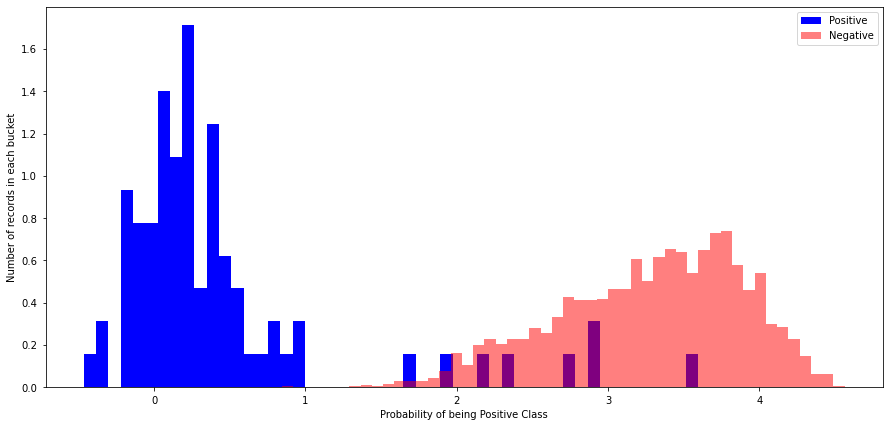

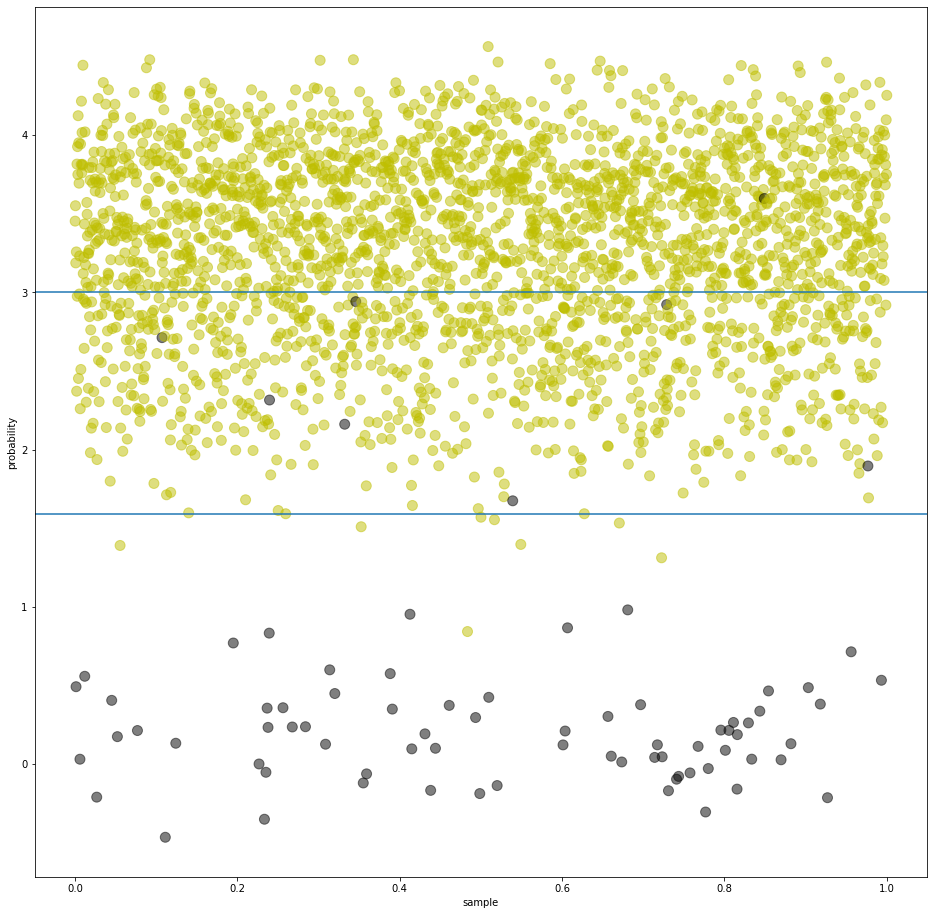

In [30]:
patients_count = X_train_copy.shape[0]

def get_optimal_threshold(model, X, full_cost, single_cost):
    threshold = 0.0
    no_patients = int(full_cost / single_cost)
    if no_patients > patients_count:
        threshold = 1.5
    else:
        prediction = (model.predict_proba(X)[:,1])
        prediction = np.sort(prediction)
        threshold = np.round(prediction[no_patients-1],2)
    return threshold
    
thresh1 = get_optimal_threshold(model, X_train_copy, 8000, 100)
thresh2 = 3.0
draw_boundary(model, X_train_copy, Y_train, thresh1, thresh2)

In [31]:
def get_decision_boundaries(prob, thresh1, thresh2):
    label = ''
    if(prob < thresh1):
        label = 'high risk'
    elif(prob < thresh2):
        label = 'risk'
    else:
        label = 'low risk'
    return label
        


In [32]:


row_to_show = 93
data_for_prediction = X_test_copy.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = (model.predict_proba(data_for_prediction_array)[:,1] >= optimal_threshold).astype(int)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
model.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction, link='logit')

predictoin [1]
actial 1.0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


100%|===================| 5398/5422 [01:10<00:00]        

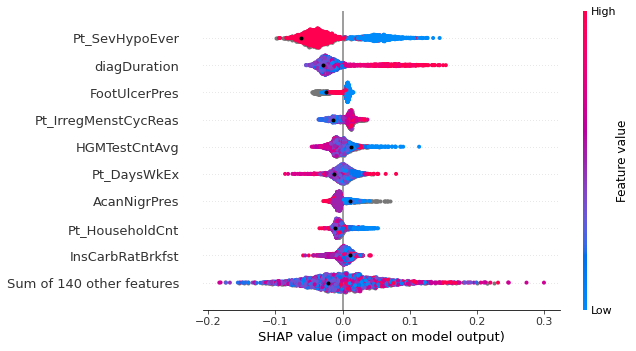

In [33]:
# compute SHAP values
explainer = shap.Explainer(model, X_train_copy)
shap_values = explainer(X_train_copy)

shap_values = shap_values[:, :, 0]
import matplotlib.pyplot as pl
shap.plots.beeswarm(shap_values, show=False)
shap.plots.beeswarm(shap_values[-1:], show=False, color="black")
pl.show()

In [34]:
pred = model.predict_proba(X_train_copy)[:,1] 
Y_train = pd.DataFrame(Y_train)
X_beeswarm = X_train_copy.copy()
X_beeswarm['pred'] = pred
X_beeswarm['Y'] = Y_train


In [ ]:
# positive but predict as negative
idx = np.where((X_beeswarm['pred']>2.9) & (X_beeswarm['Y']== 0.0) )
print(idx)

# positive and predict positive
idx2 = np.where((X_beeswarm['pred']<0) & (X_beeswarm['Y']== 0.0) )
print(idx2)

# negative but predicted as positive
idx3 = np.where((X_beeswarm['pred']<1.1) & (X_beeswarm['Y']== 1.0) )
print(idx3)

X_beeswarm.drop(['pred'], axis = 1)
X_beeswarm.drop(['Y'], axis = 1)

explainer = shap.Explainer(model, X_beeswarm)
shap_values = explainer(X_beeswarm)
shap_values = shap_values[:, :, 0]

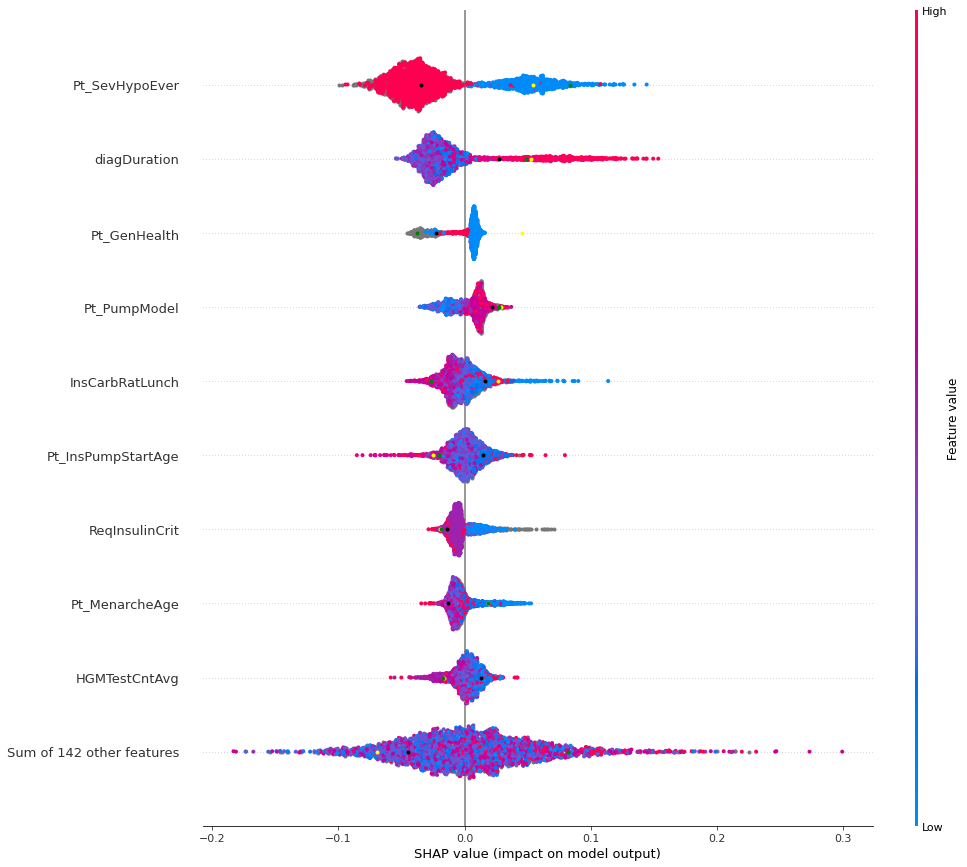

In [36]:

shap.plots.beeswarm(shap_values,
                    show=False,
                    plot_size=[15,15],
                    alpha = 1,
#                     color=plt.get_cmap("cool")
                   )
shap.plots.beeswarm(shap_values[937:938:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[301:302:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[1310:1311:], show=False, color="green", plot_size=[15,15])


plt.show()


[LightGBM] [Warning] Unknown parameter: is_unbalanced
Accuracy for the fold no. 1 on the test set: 0.9705882352941176, doublecheck: 0.9705882352941176
[LightGBM] [Warning] Unknown parameter: is_unbalanced
Accuracy for the fold no. 2 on the test set: 0.974169741697417, doublecheck: 0.974169741697417
[LightGBM] [Warning] Unknown parameter: is_unbalanced
Accuracy for the fold no. 3 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
[LightGBM] [Warning] Unknown parameter: is_unbalanced
Accuracy for the fold no. 4 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
[LightGBM] [Warning] Unknown parameter: is_unbalanced
Accuracy for the fold no. 5 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
[LightGBM] [Warning] Unknown parameter: is_unbalanced
Accuracy for the fold no. 6 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
[LightGBM] [Warning] Unknown parameter: is_unbalanced
Accuracy for the fold no. 7 on the test se

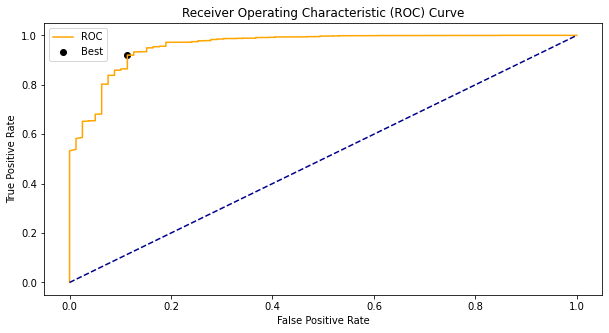

accuracy score:  91.88491331611951
              precision    recall  f1-score   support

         0.0       0.25      0.89      0.39        79
         1.0       1.00      0.92      0.96      2632

    accuracy                           0.92      2711
   macro avg       0.62      0.90      0.67      2711
weighted avg       0.97      0.92      0.94      2711



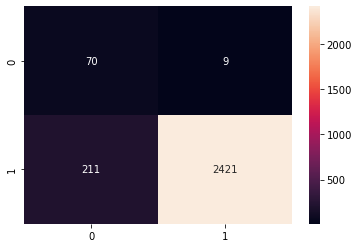

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9704415640436167


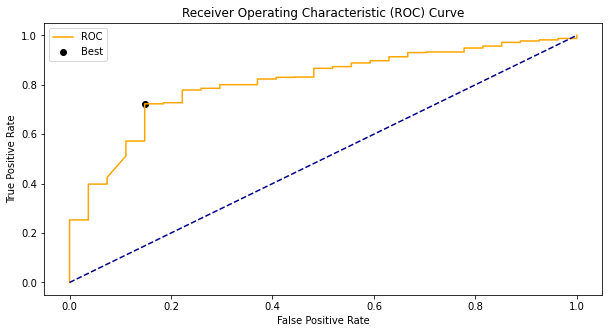

accuracy score:  72.67699115044249
              precision    recall  f1-score   support

         0.0       0.09      0.85      0.16        27
         1.0       0.99      0.72      0.84       877

    accuracy                           0.73       904
   macro avg       0.54      0.79      0.50       904
weighted avg       0.97      0.73      0.82       904



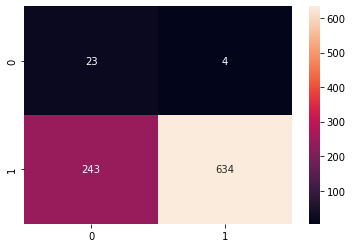



 ===========   ROC    =============
roc_auc = 0.8093


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.85185185 0.72291904]
average accuracy:  0.7873854470205668
f1 0.7267699115044248


In [26]:
# xgboost - train with missing values

model=ltb.LGBMClassifier(use_missing = True,
                         learning_rate = 0.009, 
                         is_unbalanced=True,
                         max_depth =4, random_state=0 )

# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model,10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

# test_acc = model.score(X_test_copy, Y_test)
# print('Accuracy of XGB classifier on test set: {:.2f}'
#      .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test, average = 'micro'))

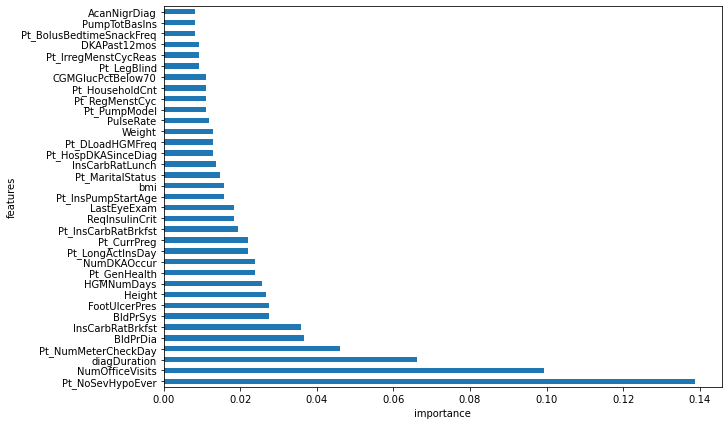

In [27]:
# feature importance graph of XGB
# feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
# feat_importances.nlargest(20).plot(kind='barh')

X_test_copy.rename(columns = {'Pt_SevHypoEver':'Pt_NoSevHypoEver'}, inplace = True)
X_train_copy.rename(columns = {'Pt_SevHypoEver':'Pt_NoSevHypoEver'}, inplace = True)


plt.figure(figsize=(10,7))
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feature_importances = pd.Series((model.feature_importances_ / sum(model.feature_importances_)), index=X_train_copy.columns[0:204])
feature_importances.nlargest(35).plot(kind='barh')
plt.xlabel("importance")
plt.ylabel("features")
plt.savefig('FISHFemale.png', bbox_inches='tight')

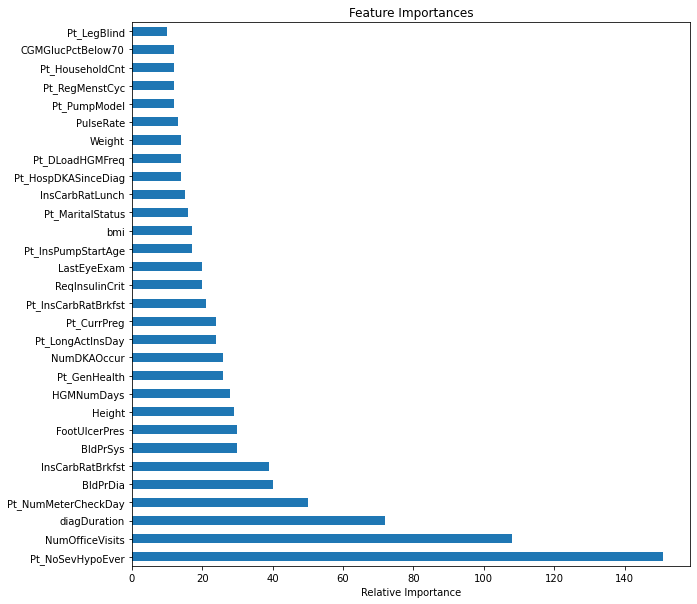

In [28]:
# feature importance graph of XGB
plt.figure(figsize=(10,10))

plt.title('Feature Importances')
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feat_importances.nlargest(30).plot(kind='barh')
plt.xlabel('Relative Importance')
plt.savefig('fiSHFeMale.png')
plt.show()


In [29]:
def draw_boundary(model, X, Y, thresh1, thresh2):
    
    prediction = (model.predict_proba(X)[:,1])
    
    X_axis= np.linspace(start = 0, stop = 1, num = len(prediction))
    d = pd.DataFrame(prediction, columns=['pre'])
    X_axis = pd.DataFrame(X_axis, columns=['x_axis_vals'])
    df = pd.concat([d.reset_index(drop=True), Y.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), X_axis.reset_index(drop=True)], axis=1)
    
    
    # plot histogram
    plt.figure(figsize=(15,7))
    plt.hist(prediction[Y==0], bins=50, label='Positive', alpha=1, color='b', density=True)
    plt.hist(prediction[Y==1], bins=50, label='Negative', alpha=0.5, color='r', density=True)
    plt.xlabel('Probability of being Positive Class', fontsize=10)
    plt.ylabel('Number of records in each bucket', fontsize=10)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', labelsize=10, pad=5)
    plt.show() 
    
    # plot scatter
    plt.figure(figsize=(16, 16))
    colormap = np.array(['k', 'y'])
    cs = df.SHSeizComaPast12mos.to_list()
    categories = np.array(cs).astype(int)
    plt.scatter(df.x_axis_vals, df.pre, s=100, c=colormap[categories], alpha=0.5)
    plt.axhline(y=thresh1, color = 'r')
    plt.axhline(y=thresh2, color = 'g')
    plt.xlabel('sample', fontsize=10)
    plt.ylabel('probability', fontsize=10)
    plt.show()

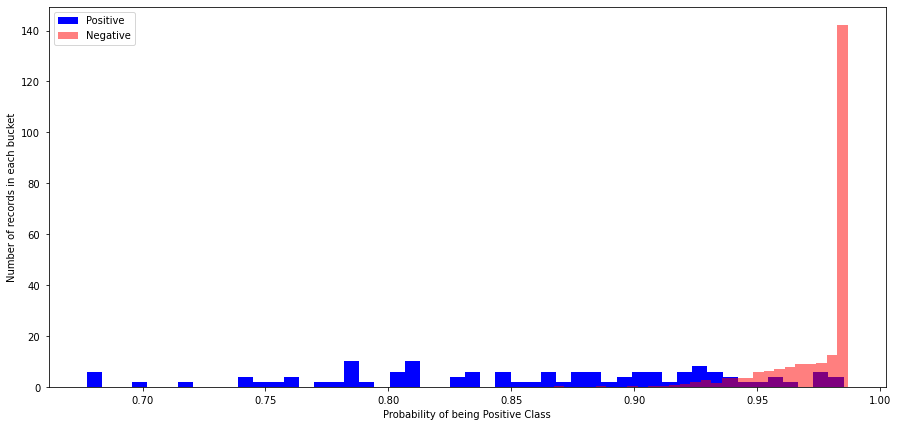

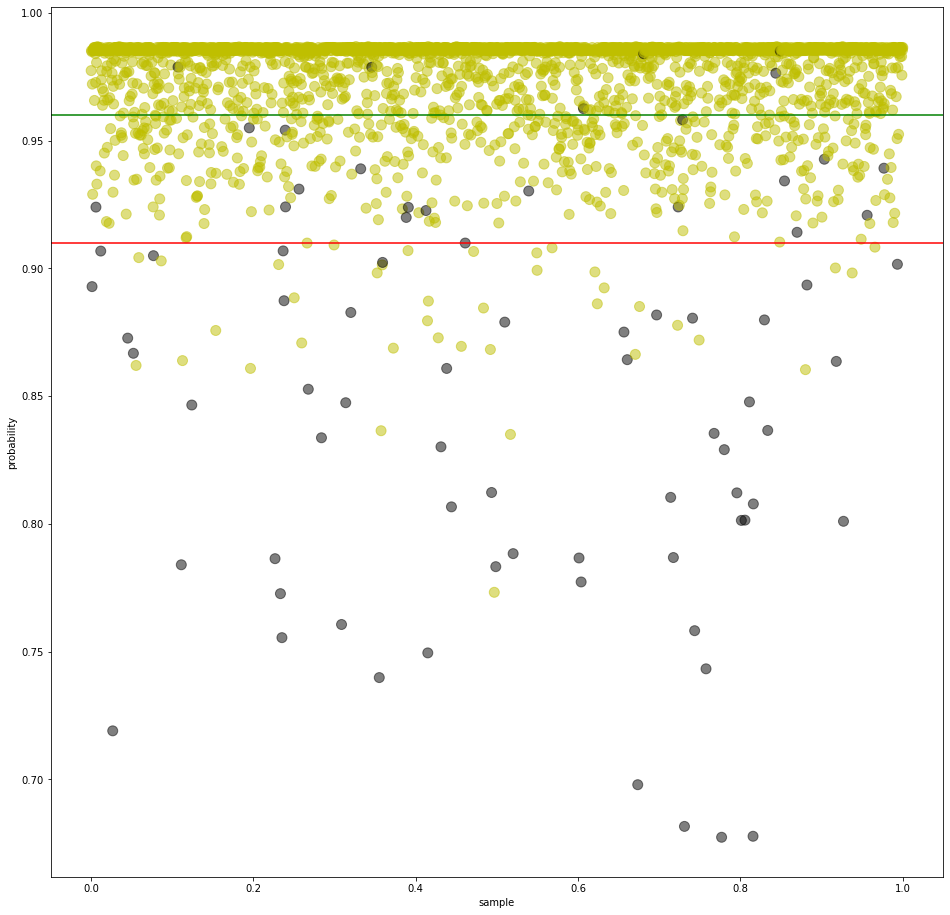

In [30]:
patients_count = X_train_copy.shape[0]

def get_optimal_threshold(model, X, full_cost, single_cost):
    threshold = 0.0
    no_patients = int(full_cost / single_cost)
    if no_patients > patients_count:
        threshold = 0.85
    else:
        prediction = (model.predict_proba(X)[:,1])
        prediction = np.sort(prediction)
        threshold = np.round(prediction[no_patients-1],2)
    return threshold
    
thresh1 = get_optimal_threshold(model, X_train_copy, 17000, 200)
thresh2 = 0.96
draw_boundary(model, X_train_copy, Y_train, thresh1, thresh2)

In [31]:
def get_decision_boundaries(prob, thresh1, thresh2):
    label = ''
    if(prob < thresh1):
        label = 'high risk'
    elif(prob < thresh2):
        label = 'risk'
    else:
        label = 'low risk'
    return label


predictoin [1]
actial 0.0


Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[0.3095045156046044, -0.014960091822817682, 0.007066620803134354, 0.006530021007133207, 0.0038443487529426688, 0.013505789784392465, 0.0039597096226055405, 0.017512329906669403, 0.0032171640912829875, -0.005693946220968938, 0.008771676639960414, 0.004795971604757458, 0.006954453750798545, -0.004681408218911463, 0.005135511990424684, -0.007603627421042393, 0.0034561028217129936, 0.0037273706215614133, -0.04077525974225565, -0.011643821890813014, 0.031149182855589232, 0.003643251853989385, 0.003876231180201392, 0.004330238799168949, 0.006108160643397967, 0.04528345893461917]
['Pt_NoSevHypoEver=1.0', 'Pt_InsCarbRatBrkfst=15.0', 'Pt_InsPumpStartAge=40.0', 'Pt_PumpModel=4.0', 'Pt_LongActInsDay=nan', 'Pt_NumMeterCheckDay=4.0', 'Pt_DLoadHGMFreq=0.0', 'Pt_GenHealth=2.0', 'Pt_CurrPreg=1.0', 'Pt_HouseholdCnt=1.0', 'ReqInsulinCrit=2.0', 'NumDKAOccur=nan', 'Height=1.665', 'BldPrSys=132.0', 'BldPrDia=91.0', 'HGMNumDays=nan', 'CGMGlucPctBelow70=nan', 'AcanNigrDiag=2.0', 'FootUlcerPres=1.0', 'NumOffi

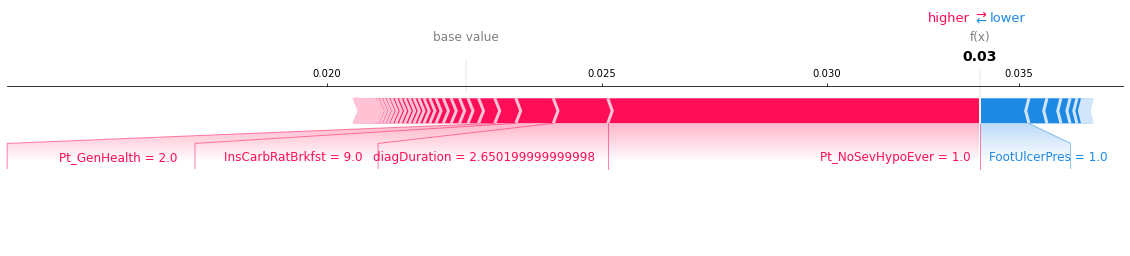

In [32]:
X_test_copy.rename(columns = {'Pt_SevHypoEver':'Pt_NoSevHypoEver'}, inplace = True)
X_train_copy.rename(columns = {'Pt_SevHypoEver':'Pt_NoSevHypoEver'}, inplace = True)

row_to_show = 91
data_for_prediction = X_test_copy.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = (model.predict_proba(data_for_prediction_array)[:,1] >= optimal_threshold).astype(int)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
model.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).
import matplotlib.pyplot as pl
shap.force_plot(explainer.expected_value[0], shap_values[1], data_for_prediction, link='logit', show=False, matplotlib=True)
plt.savefig('shFemaleLocalinterpret.png' ,bbox_inches='tight')

sv = shap_values[1][0,:]

mapping = dict(zip(X_train_copy.columns.tolist(), list(data_for_prediction)))
data = list(mapping.values())
key = list(mapping.keys())
arr = []

for i, val in enumerate(key):
    a = val+'='+ str(data[i])
    arr.append(a)

new_sv = []
new_arr = []

for i, val in enumerate(sv):
    isRange = False
    if((0. <= sv[i] <= 0.003) or (0.0 >= sv[i] >= -0.003)):
        isRange = True
    if(sv[i] != 0. and not isRange ):
        new_sv.append(sv[i])
        new_arr.append(arr[i])

print(new_sv)
print(new_arr)
# shap.force_plot(explainer.expected_value[0], shap_values[1], data_for_prediction, link='logit')

In [33]:
sorted_arr = [x for _,x in sorted(zip(new_sv,new_arr), reverse=True)]
print(sorted_arr)
sorted_sv = sorted(new_sv, reverse=True)

['Pt_NoSevHypoEver=1.0', 'diagDuration=2.650199999999998', 'InsCarbRatBrkfst=9.0', 'Pt_GenHealth=2.0', 'Pt_NumMeterCheckDay=4.0', 'ReqInsulinCrit=2.0', 'Pt_InsPumpStartAge=40.0', 'Height=1.665', 'Pt_PumpModel=4.0', 'bmi=34.05207008810613', 'BldPrDia=91.0', 'NumDKAOccur=nan', 'DKAPast12mos=1.0', 'Pt_DLoadHGMFreq=0.0', 'GFRBelow60=nan', 'Pt_LongActInsDay=nan', 'AcanNigrDiag=2.0', 'InsCarbRatLunch=9.0', 'CGMGlucPctBelow70=nan', 'Pt_CurrPreg=1.0', 'BldPrSys=132.0', 'Pt_HouseholdCnt=1.0', 'HGMNumDays=nan', 'NumOfficeVisits=5.0', 'Pt_InsCarbRatBrkfst=15.0', 'FootUlcerPres=1.0']


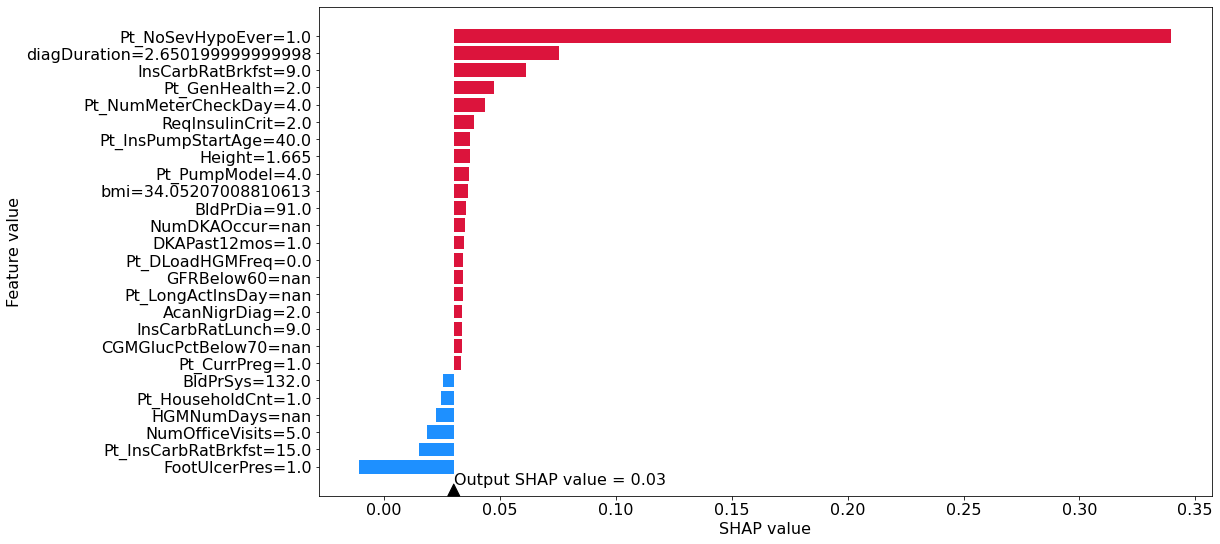

In [34]:
threshold = 0.03
plt.rcParams.update({'font.size': 16})

color = ['crimson' if e >= 0.00 else 'dodgerblue' for e in sorted_sv]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(sorted_arr, sorted_sv, color=color, left = threshold)

ax.annotate('Output SHAP value = 0.03', xy=(threshold,26),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

# Show top values
ax.invert_yaxis()
plt.xlabel('SHAP value', fontsize=16)
plt.ylabel('Feature value', fontsize=16)
plt.savefig('SHfemalelocalNew.png' ,bbox_inches='tight')

# Show Plot
plt.show()

In [ ]:
# compute SHAP values
explainer = shap.Explainer(model, X_train_copy)
shap_values = explainer(X_train_copy)

import matplotlib.pyplot as pl
shap.plots.beeswarm(shap_values, max_display=35, show=False, plot_size=[15,15])
pl.savefig('SHFemalebeeswarm.png', bbox_inches='tight')

pl.show()




In [ ]:
X_train_copy['Pt_InsCarbRatBrkfst'].mean()

In [ ]:
if is_male:
    
    X_train.update(X_train[[
                 'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
                 'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
                 'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
                 ]].fillna(0))

    X_test.update(X_test[[
                 'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
                 'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
                 'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
                 ]].fillna(0))
else:
    X_train.update(X_train[[
             'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
             'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
             ]].fillna(0))

    X_test.update(X_test[[
             'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
             'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
             ]].fillna(0))

In [ ]:
# X_train = X_train_copy
# X_test = X_test_copy

In [ ]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
# imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
imputeX = IterativeImputer(missing_values=np.nan,sample_posterior= True,max_iter=15,
                           initial_strategy='most_frequent', random_state=0)

X_train = imputeX.fit_transform(X_train)


In [ ]:
# ###############
# import datawig

# imputer = datawig.SimpleImputer()
# imputer.fit(train_df = X_train, num_epochs=50)
# X_test = imputer.predict(X_test)
# X_train = imputer.predict(X_train)

In [ ]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)



# Scale data

In [ ]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
select[0] = pd.DataFrame(scaler.fit_transform(X_train))
select[1] = Y_train
select[2] = pd.DataFrame(scaler.transform(X_test))


## Feature Selection

In [ ]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [ ]:


#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 5) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])

    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [ ]:
# Feature selection
selected, fs, idx = select_features(select, feature)


In [ ]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)



In [ ]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


In [ ]:
# X_train.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)
# X_test.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)

# if('Pt_SevHypoEver' in X_train.columns):
#     X_train = X_train.drop(['Pt_SevHypoEver'], axis=1)
#     X_test = X_test.drop(['Pt_SevHypoEver'], axis=1)
if('NumSHSeizComaPast12mos' in X_train.columns):
    X_train = X_train.drop(['NumSHSeizComaPast12mos'], axis=1)
    X_test = X_test.drop([ 'NumSHSeizComaPast12mos'], axis=1)
    
if('Pt_v3NumSHSeizComa' in X_train.columns):
    X_train = X_train.drop(['Pt_v3NumSHSeizComa'], axis=1)
    X_test = X_test.drop(['Pt_v3NumSHSeizComa'], axis=1)


### Common functions

In [ ]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model, n_splits=10):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train.columns]
#         X_test1 = train.iloc[test_index][X_train.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model



    dfs = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    return model



In [ ]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
    optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
#     optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr, optimal_idx)
    plt.show()
    return optimal_threshold

In [ ]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    
    train_acc = model.score(X_train, Y_train)
    print('Accuracy of on training set: {:.2f}'.format(train_acc))

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    
    test_acc = model.score(X_test, Y_test)
    print('Accuracy of classifier on test set: {:.2f}'
         .format(test_acc))

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('average accuracy: ',( np.sum(acc)/2))
    
    print('f1', metrics.f1_score(pred, Y_test, average = 'micro'))    

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

ltb_model=ltb.LGBMClassifier(use_missing = False,
                         learning_rate = 0.01, 
                         max_depth =4, random_state=0 )
# adaboost.fit(X_train, Y_train)
ltb_model = cross_val(ltb_model, 10)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(ltb_model, X_train, Y_train)
pred_train = (ltb_model.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(ltb_model, X_test, Y_test)
pred = (ltb_model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(ltb_model, X_train, Y_train, pred_train)
test_results(ltb_model, X_test, Y_test, pred)

# ROC
ROC_results(ltb_model, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(ltb_model, Y_test, pred)


In [ ]:
feat_importances = pd.Series(ltb_model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

### Adaboost model

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0,
                              learning_rate=0.008,
                              n_estimators=750,
                              algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost, 10)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


In [ ]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

# Model - XGB

In [ ]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
#         max_delta_step = 10,
#         subsample = 0.5,#values between(0.5-1)
#         colsample_bytree = 1,#values between(0.5-1)
#         tree_method = "auto",
#         process_type = "default",
#         num_parallel_tree=7,
        objective = 'binary:logistic', 
#         objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
#         num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute,10)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



In [ ]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

In [ ]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=4,
                             n_estimators = feature,
                             criterion = 'entropy', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.001,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf,10)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(rf, X_test, Y_test)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## Model 3 LogisticRegression

In [ ]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg,10)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

In [ ]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 6 - Linear Discriminant Analysis

In [ ]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(lda, X_test, Y_test)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


In [ ]:
feat_importances = pd.Series(lda.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 7- Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB(priors=None, var_smoothing=1)
gnb = cross_val(gnb)
# gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)


In [ ]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(gnb, X_test, Y_test)

feat_importances = pd.Series(imps.importances_mean, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')